In [49]:
import librosa
import numpy as np
import pandas as pd
import pickle
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [50]:
def find_anchor_frame(beats, tempo, sr):
    # Convert tempo to interval in seconds between beats
    seconds_per_beat = 60.0 / tempo
    
    # Convert interval to expected frames between beats
    expected_interval = int(librosa.time_to_frames(seconds_per_beat, sr=sr))
    
    # Calculate the difference between consecutive beats
    beat_intervals = np.diff(beats)
    
    # Initialize variables to keep track of the best matching sequence
    best_match_start = None
    best_match_quality = 0
    
    # Sliding window size based on a small multiplier of the expected interval to capture tempo variations
    window_size = 3  # Small window to check consistency of intervals
    
    # Iterate through beat intervals with a sliding window
    for i in range(len(beat_intervals) - window_size + 1):
        window = beat_intervals[i:i+window_size]
        
        # Calculate the average interval in the current window and its match quality
        avg_interval = np.mean(window)
        match_quality = 1 - abs(avg_interval - expected_interval) / expected_interval
        
        # Update the best match if this window represents a higher quality match
        if match_quality > best_match_quality:
            best_match_start = beats[i]
            best_match_quality = match_quality
            
            # Early exit condition if the match quality is high enough
            if match_quality > 0.95:
                return best_match_start
    
    return best_match_start


def create_beat_grid(beats, anchor_frame, sr, beat_interval_in_frames, time_signature, duration):
    """Creates a grid of measures based on the tempo, time signature, and beats of the song."""
    duration_in_frames = int(librosa.time_to_frames(duration, sr=sr))
    
    if not anchor_frame:
        anchor_frame = beats[0]

    # Add beats before the first onset (working backwards)
    beat_grid = [anchor_frame]
    current_frame = anchor_frame
    while current_frame >= 0:
        current_frame -= beat_interval_in_frames
        beat_grid.insert(0, current_frame)

    # Remove the first beat if it's negative
    if beat_grid[0] < 0:
        beat_grid.pop(0)

    # Add beats after the anchor frame
    current_frame = anchor_frame + beat_interval_in_frames
    while current_frame <= duration_in_frames:
        beat_grid.append(current_frame)
        current_frame += beat_interval_in_frames 
        
    # Group beats into measures
    measure_grid = []
    current_frame = beat_grid[0]
    while current_frame <= duration_in_frames:
        measure_grid.append(current_frame)
        current_frame += beat_interval_in_frames * time_signature
    
    return np.array(beat_grid), np.array(measure_grid)

In [37]:
df = pd.read_csv('../data/dataframes/clean_labeled.csv')
anchor_dict = {}
# Iterate through the DataFrame and prepare data for each song
for _, group in tqdm(df.groupby('SongID'), desc='Processing'):
    song_id = group['SongID'].values[0]
    audio_path = group['FilePath'].values[0]
    y, sr = librosa.load(audio_path, sr=None)
    # Extract tempo, beat frames, and time signature
    C = np.abs(librosa.cqt(y=y, sr=sr))
    onset_env = librosa.onset.onset_strength(sr=sr, S=librosa.amplitude_to_db(C, ref=np.max))
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    sp_tempo = group['sp_tempo'].values[0] if not pd.isna(group['sp_tempo'].values[0]) else tempo
    if sp_tempo == 0:
        sp_tempo = tempo
    if sp_tempo > 140:
        sp_tempo /= 2
    if sp_tempo <= 70:
        sp_tempo *= 2
    anchor = find_anchor_frame(beats, sp_tempo, sr)
    anchor_dict[song_id] = anchor

Processing:   0%|          | 0/332 [00:00<?, ?it/s]

In [52]:
def extract_scaled_melspec(y, sr, n_fft=2048, hop_length=512, n_mels=128):
    """Extracts a Mel-spectrogram from an audio signal."""
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_dB = librosa.power_to_db(S, ref=np.max)
    min_val = np.min(S_dB)
    max_val = np.max(S_dB)
    scaled_melspec = (S_dB - min_val) / (max_val - min_val)
    return scaled_melspec

In [66]:
song_id = group['SongID'].values[0]
audio_path = group['FilePath'].values[0]
hop_length = 512
y, sr = librosa.load(audio_path, sr=None)
duration = librosa.get_duration(y=y, sr=sr)
scaled_melspec = extract_scaled_melspec(y, sr)

In [55]:
C = np.abs(librosa.cqt(y=y, sr=sr))
onset_env = librosa.onset.onset_strength(sr=sr, S=librosa.amplitude_to_db(C, ref=np.max))
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr,
                                      hop_length=512)

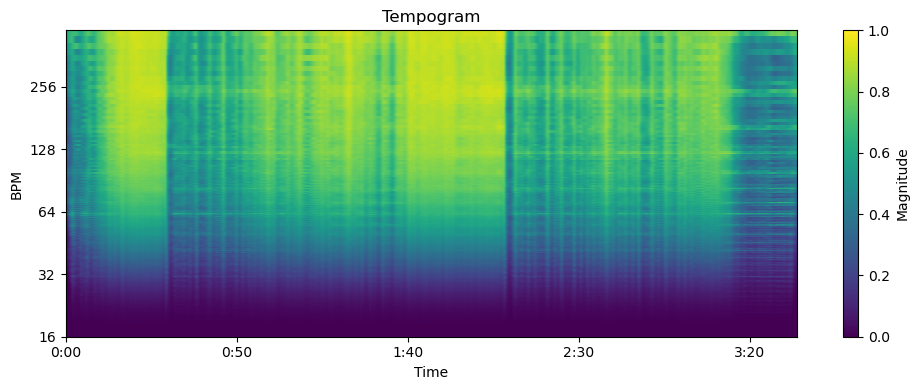

In [63]:
# Plot the tempogram
plt.figure(figsize=(10, 4))

# Use librosa.display.specshow to plot the tempogram
librosa.display.specshow(tempogram, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='tempo', cmap='viridis')

plt.colorbar(label='Magnitude')
plt.title('Tempogram')
plt.tight_layout()
plt.show()

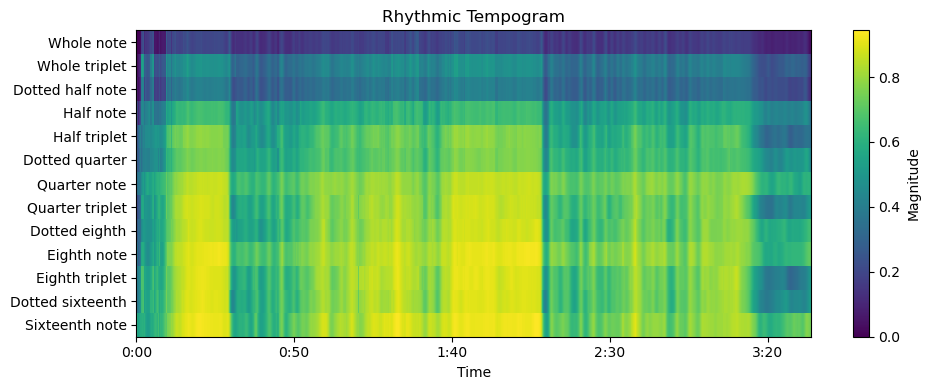

In [70]:
tgr = librosa.feature.tempogram_ratio(tg=tempogram, sr=sr)
# Define note labels
note_labels = [
    'Sixteenth note',
    'Dotted sixteenth',
    'Eighth triplet',
    'Eighth note',
    'Dotted eighth',
    'Quarter triplet',
    'Quarter note',
    'Dotted quarter',
    'Half triplet',
    'Half note',
    'Dotted half note',
    'Whole triplet',
    'Whole note'
]

# Plot the tempogram
fig, ax = plt.subplots(figsize=(10, 4))  # Use plt.subplots() instead of plt.figure()

# Assuming 'tgr' is your tempogram_ratio array and already computed
# Example of plotting using specshow
img = librosa.display.specshow(tgr, sr=sr, hop_length=hop_length,
                               x_axis='time', ax=ax, cmap='viridis')
                         
# Assuming 'tgr' has a vertical dimension corresponding to the entries in note_labels
# Set custom y-ticks to correspond to note_labels
ax.set_yticks(np.arange(len(note_labels)))
ax.set_yticklabels(note_labels)

# Set the x-axis limit to the duration of the audio in seconds if needed
# This might require calculation based on the tempogram's time resolution and the total number of frames
# ax.set_xlim([0, duration]) # Uncomment and adjust 'duration' as necessary

plt.colorbar(mappable=img, ax=ax, label='Magnitude')
plt.title('Rhythmic Tempogram')
plt.tight_layout()
plt.show()

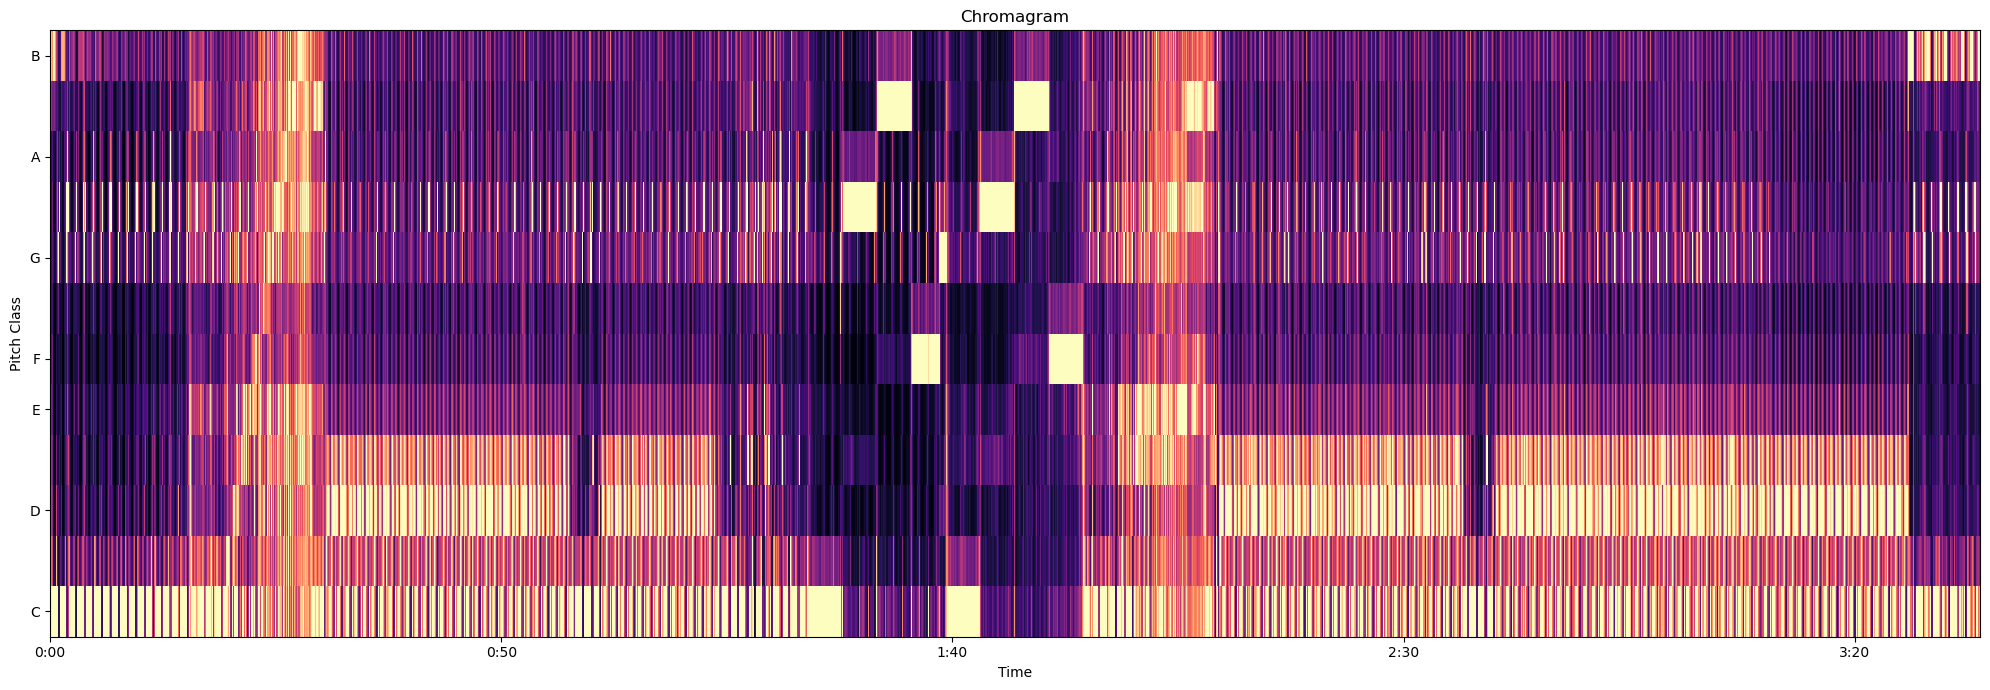

In [86]:
chromagram = librosa.feature.chroma_cqt(y=y, sr=sr)

fig, ax = plt.subplots(figsize=(20, 7))
librosa.display.specshow(chromagram, sr=sr, hop_length=hop_length, y_axis='chroma', x_axis='time')
ax.set_ylabel('Pitch Class')
ax.set_title('Chromagram')

plt.tight_layout()
plt.show()

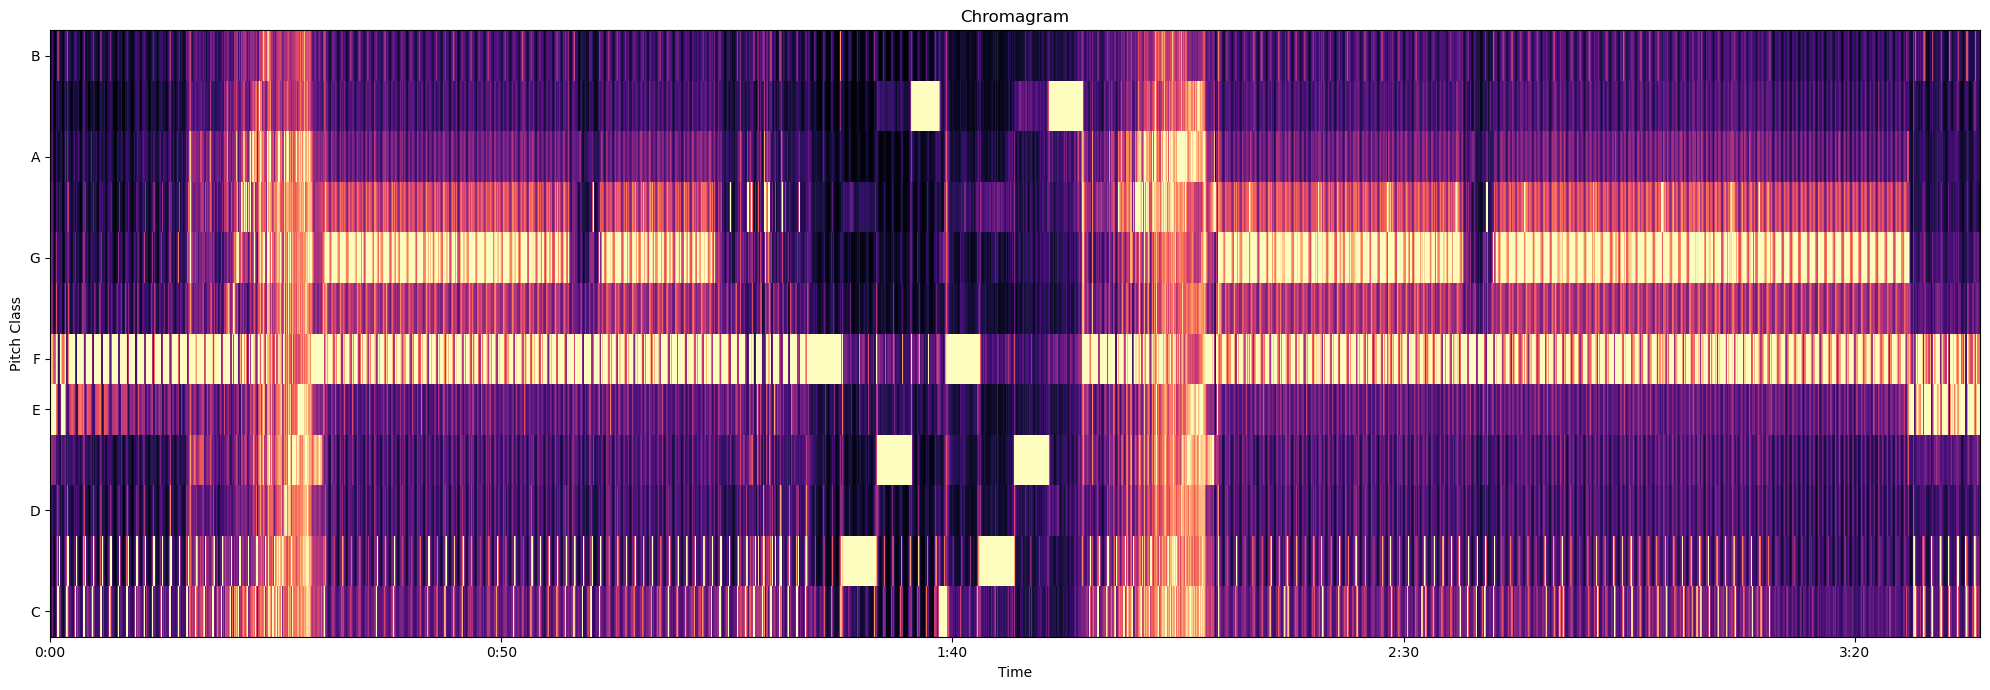

In [87]:
chromagram = librosa.feature.chroma_cqt(y=y, sr=sr)

fig, ax = plt.subplots(figsize=(20, 7))
librosa.display.specshow(chromagram, sr=sr, hop_length=hop_length, y_axis='chroma', x_axis='time')
ax.set_ylabel('Pitch Class')
ax.set_title('Chromagram')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Tonnetz features')

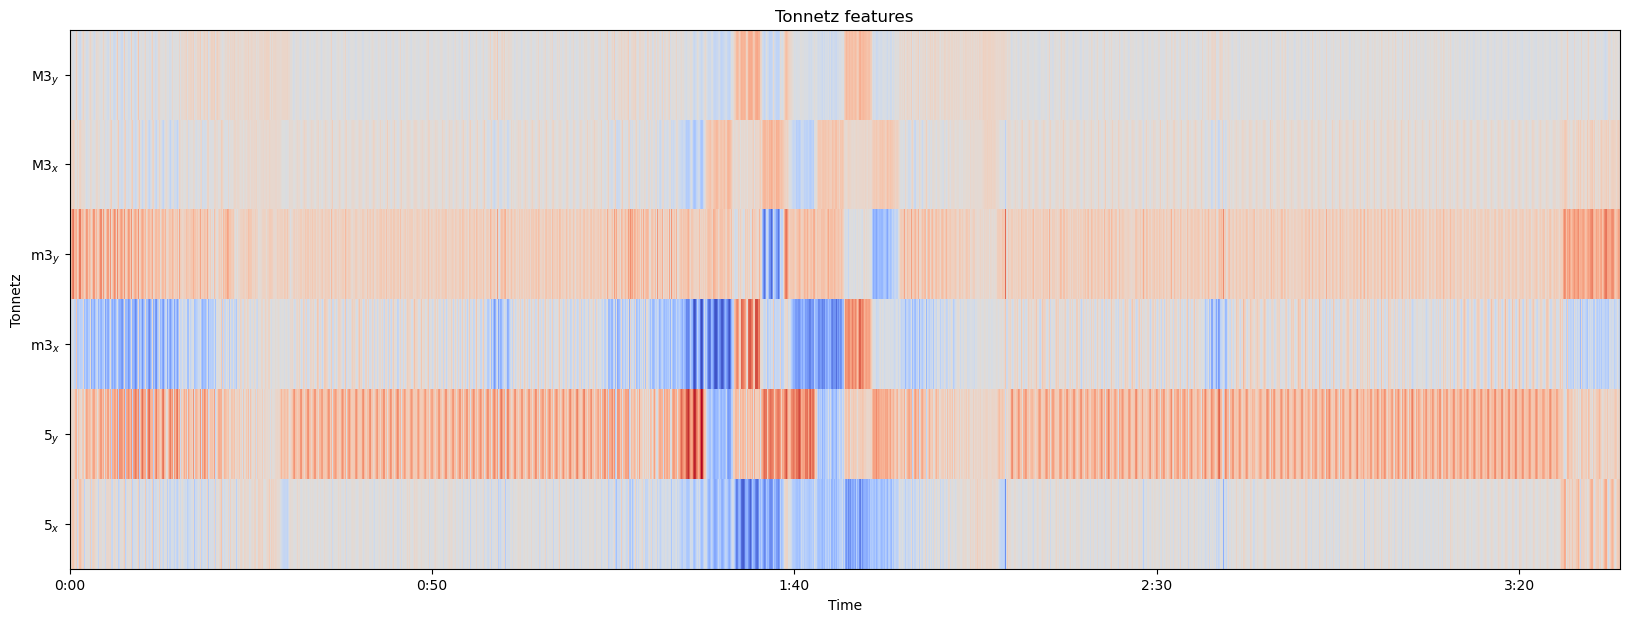

In [80]:
tonnetz = librosa.feature.tonnetz(y=y, sr=sr, chroma=chromagram)

fig, ax = plt.subplots(figsize=(20, 7))
librosa.display.specshow(tonnetz, sr=sr, hop_length=hop_length, y_axis='tonnetz', x_axis='time')
ax.set_title('Tonnetz features')

Text(0.5, 1.0, 'Tonnetz features')

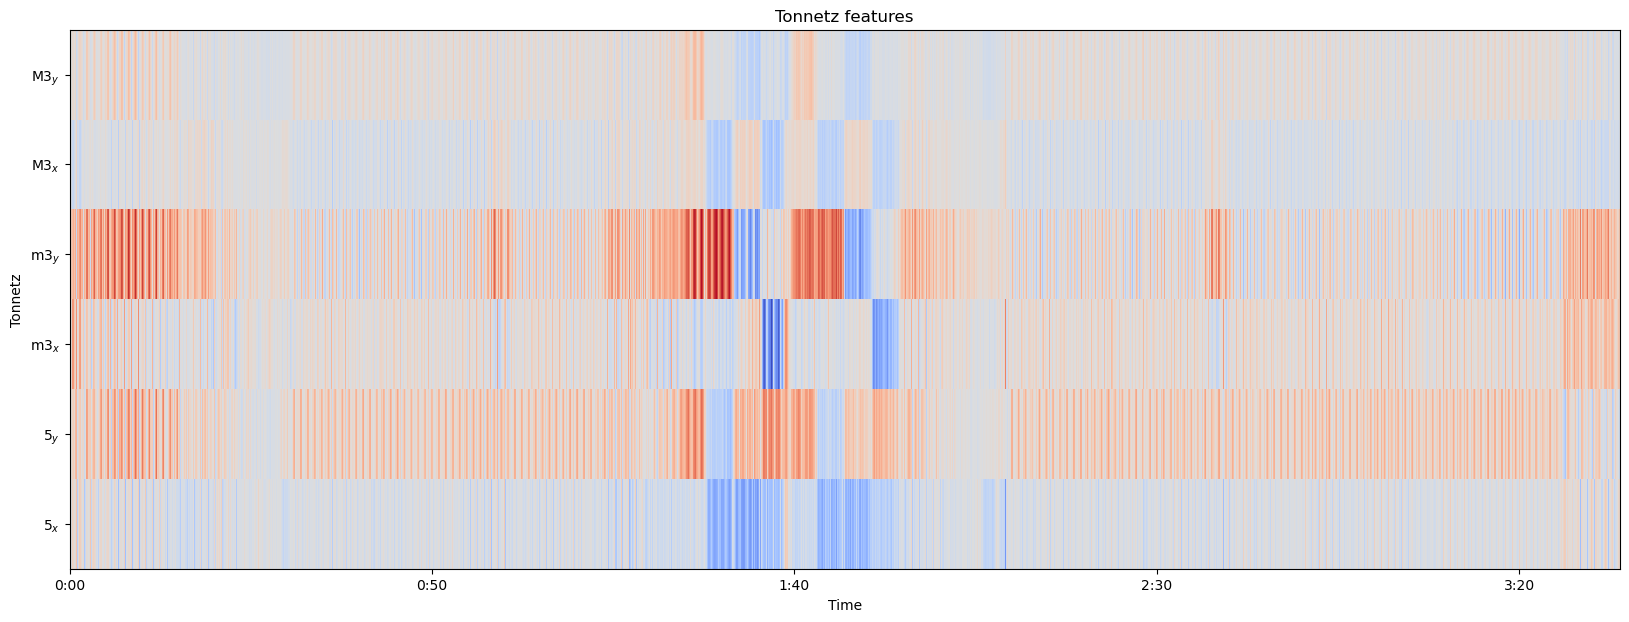

In [89]:
tonnetz = librosa.feature.tonnetz(y=None, sr=sr, chroma=key_invariant_chromagram)

fig, ax = plt.subplots(figsize=(20, 7))
librosa.display.specshow(tonnetz, sr=sr, hop_length=hop_length, y_axis='tonnetz', x_axis='time')
ax.set_title('Tonnetz features')

In [90]:
def make_key_invariant_chromagram(y, sr):
    # Compute the chromagram
    chromagram = librosa.feature.chroma_cqt(y=y, sr=sr, bins_per_octave=24)
    
    # Calculate the chroma values to determine the key
    chroma_vals = [np.sum(chromagram[i]) for i in range(12)]
    pitches = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    keyfreqs = {pitches[i]: chroma_vals[i] for i in range(12)}
    
    # Define major and minor profiles for key correlation
    maj_profile = [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
    min_profile = [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]
    
    # Compute correlations for all keys
    maj_key_corrs = [np.corrcoef(maj_profile, [keyfreqs.get(pitches[(i + m) % 12]) for m in range(12)])[1,0] for i in range(12)]
    min_key_corrs = [np.corrcoef(min_profile, [keyfreqs.get(pitches[(i + m) % 12]) for m in range(12)])[1,0] for i in range(12)]
    keys = [p + ' major' for p in pitches] + [p + ' minor' for p in pitches]
    key_corrs = dict(zip(keys, maj_key_corrs + min_key_corrs))
    
    # Identify the key with the highest correlation
    key = max(key_corrs, key=key_corrs.get)
    
    # Determine tonic index and make chromagram key-invariant
    tonic = key.split()[0]
    tonic_index = pitches.index(tonic)
    key_invariant_chromagram = np.roll(chromagram, -tonic_index, axis=0)
    
    return key_invariant_chromagram

In [91]:
key_invariant_chromagram = make_key_invariant_chromagram(y, sr)

[Text(0.5, 1.0, 'log Power spectrogram')]

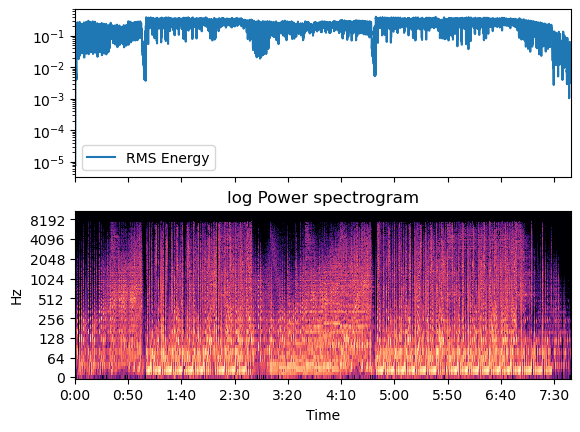

In [93]:
S, phase = librosa.magphase(librosa.stft(y))
rms = librosa.feature.rms(S=S)

fig, ax = plt.subplots(nrows=2, sharex=True)
times = librosa.times_like(rms)
ax[0].semilogy(times, rms[0], label='RMS Energy')
ax[0].set(xticks=[])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')

In [95]:
# Compute the RMS feature
rms = librosa.feature.rms(y=y)

# Min-Max normalization within songs
rms_normalized = (rms - np.min(rms, axis=1, keepdims=True)) / (np.max(rms, axis=1, keepdims=True) - np.min(rms, axis=1, keepdims=True))

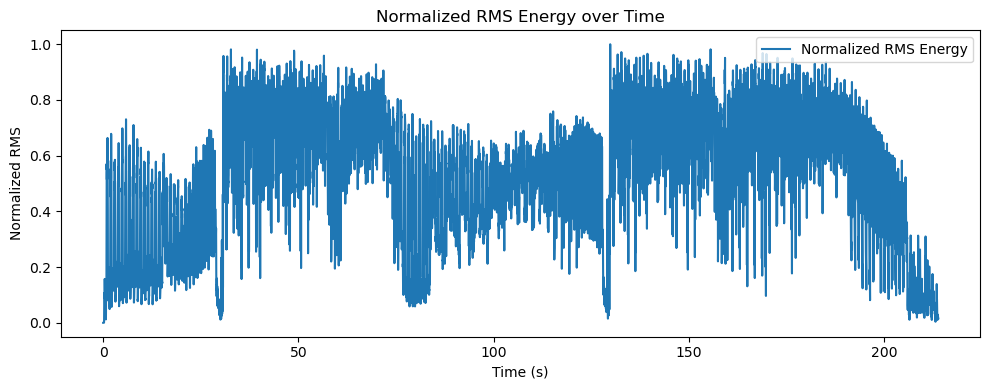

In [98]:
# Time vector for x-axis, assuming hop_length=512 and sr is your audio's sampling rate
times = np.arange(rms_normalized.shape[1]) * 512 / sr

plt.figure(figsize=(10, 4))
plt.plot(times, rms_normalized.T, label='Normalized RMS Energy')
plt.xlabel('Time (s)')
plt.ylabel('Normalized RMS')
plt.title('Normalized RMS Energy over Time')
plt.legend()
plt.tight_layout()
plt.show()

In [100]:
print(rms_normalized.shape, tgr.shape, tonnetz.shape, key_invariant_chromagram.shape)

(1, 20051) (13, 20051) (12, 20051) (6, 20051) (12, 20051)


In [101]:
combined_features = np.concatenate([rms_normalized, tgr, key_invariant_chromagram, tonnetz], axis=0)
combined_features.shape

(32, 20051)

In [102]:
librosa.frames_to_time(len(combined_features.T), sr=sr, hop_length=512)

213.87733333333333

In [104]:
int(librosa.time_to_frames(60 / tempo, sr=sr))

45

In [106]:
len(combined_features[0])

20051

In [108]:
np.concatenate([rms_normalized, tgr, key_invariant_chromagram, tonnetz], axis=0).T.shape

(20051, 32)